# Tarea 2 Ingeniería Financiera

Este Notebook contiene el análisis completo seccionado por pregunta.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sco

excel_file_path = 'Base de datos completa.xlsx'

sheet_names_stocks_usd = {
    'AAPL': 'Apple',
    'KO': 'Coca-Cola',
    'BCH': 'Banco De Chile',
    'CCU': 'Cervecerias',
    'ENELCH': 'Enel Chile',
    'LTM': 'LATAM Airlines'
}
sheet_name_fx = 'Tipo de Cambio'

num_trading_days_year = 252


In [15]:
# Leer todas las hojas del archivo Excel
ruta_archivo = "Base de datos completa.xlsx"  # Ajustar ruta si es necesario
datos = pd.read_excel(ruta_archivo, sheet_name=None)

In [16]:
# Definir número de activos (excluyendo la hoja 'Tipo de Cambio')
n_assets = len([sheet for sheet in datos.keys() if sheet != 'Tipo de Cambio'])

In [17]:
# Mostrar las primeras filas de cada hoja
for hoja, df in datos.items():
    print(f"Hoja: {hoja}")
    print(df.head())

Hoja: Tipo de Cambio
        Date   Price
0 2022-04-25  834.45
1 2022-04-26  850.85
2 2022-04-27  847.57
3 2022-04-28  847.44
4 2022-04-29  856.58
Hoja: Apple Stock Price History (3)
        Date   Price
0 2022-04-25  162.88
1 2022-04-26  156.80
2 2022-04-27  156.57
3 2022-04-28  163.64
4 2022-04-29  157.65
Hoja: Coca-Cola Stock Price History (
        Date  Price
0 2022-04-25  65.94
1 2022-04-26  65.05
2 2022-04-27  65.56
3 2022-04-28  66.19
4 2022-04-29  64.61
Hoja: Banco De Chile Stock Price Hist
        Date  Price
0 2022-04-25  20.95
1 2022-04-26  20.67
2 2022-04-27  20.60
3 2022-04-28  20.14
4 2022-04-29  20.08
Hoja: Cervecerias ADR Stock Price His
        Date  Price
0 2022-04-25  13.40
1 2022-04-26  13.34
2 2022-04-27  13.37
3 2022-04-28  13.37
4 2022-04-29  13.34
Hoja: Enel Chile ADR Stock Price Hist
        Date  Price
0 2022-04-25   1.42
1 2022-04-26   1.36
2 2022-04-27   1.33
3 2022-04-28   1.36
4 2022-04-29   1.34
Hoja: LATAM Airlines ADR Stock Price 
        Date    Price

In [18]:
log_returns = {}

# Preparar tipo de cambio si existe
exchange_rate = datos.get("Tipo de Cambio")
if exchange_rate is not None and not exchange_rate.empty:
    exchange_rate['Date'] = pd.to_datetime(exchange_rate['Date'])
    exchange_rate.sort_values('Date', inplace=True)

# Procesar cada hoja de datos
for asset, df in datos.items():
    # Omitir hoja de tipo de cambio o data inválida
    if asset == "Tipo de Cambio" or df.empty or 'Date' not in df.columns or 'Price' not in df.columns:
        continue

    # Convertir fechas y ordenar
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)

    # Ajustar precios a pesos si existe tipo de cambio
    if exchange_rate is not None and not exchange_rate.empty:
        df = pd.merge(df, exchange_rate[['Date', 'Price']], on='Date', how='left', suffixes=('', '_tc'))
        df['Price'] *= df['Price_tc']  # Convertir a pesos

    # Filtrar datos hasta un año antes de la última fecha disponible
    cutoff = df['Date'].max() - pd.DateOffset(years=1)
    df = df[df['Date'] <= cutoff].copy()

    # Calcular retornos logarítmicos diarios
    df['log_return'] = np.log(df['Price'] / df['Price'].shift(1))

    # Guardar resultados sin valores nulos
    log_returns[asset] = df.dropna(subset=['log_return'])


In [19]:
expected_returns_annual = {}
volatility_annual = {}

# Anualización de estadísticas diarias (252 días hábiles al año)
for asset, df in log_returns.items():
    mu = df['log_return'].mean() #Retorno promedio
    sigma = df['log_return'].std() #Desviación.
    expected_returns_annual[asset] = mu * 252
    volatility_annual[asset] = sigma * np.sqrt(252)

# Mostrar resultados
print("Retornos esperados anuales:")
for asset, r in expected_returns_annual.items():
    print(f"{asset}: {r:.4%}")

print("\n Volatilidades anuales:")
for asset, v in volatility_annual.items():
    print(f"{asset}: {v:.4%}")


Retornos esperados anuales:
Apple Stock Price History (3): 6.4235%
Coca-Cola Stock Price History (: -0.9920%
Banco De Chile Stock Price Hist: 8.0665%
Cervecerias ADR Stock Price His: 3.2947%
Enel Chile ADR Stock Price Hist: 37.6500%
LATAM Airlines ADR Stock Price : 70.9913%

 Volatilidades anuales:
Apple Stock Price History (3): 31.7011%
Coca-Cola Stock Price History (: 22.7095%
Banco De Chile Stock Price Hist: 31.5361%
Cervecerias ADR Stock Price His: 33.8403%
Enel Chile ADR Stock Price Hist: 48.4899%
LATAM Airlines ADR Stock Price : 107.5772%


In [20]:
# Armar DataFrame de retornos alineado por fecha
returns_df = pd.DataFrame({
    asset: df.set_index('Date')['log_return'] for asset, df in log_returns.items()
})

returns_df.dropna(inplace=True)  # Alinear fechas comunes

# Crear DataFrame de volatilidades anuales
volatility_df = pd.DataFrame({
    'Volatility': volatility_annual
}).T


volatility_df.dropna(inplace=True)  # Alinear fechas comunes



# Calcular matriz de covarianza anualizada
cov_annual = returns_df.cov() * 252

# Parte (b): Frontera Eficiente (con ventas cortas)

Calculamos la frontera eficiente de Markowitz que permite ventas cortas, usando los retornos esperados en CLP y la matriz de covarianza basada en USD.

In [21]:
cov_inv = np.linalg.inv(cov_annual) # Inversa de covarianza

# Convertir a arrays para cálculos matriciales
mu = np.array([expected_returns_annual[asset] for asset in returns_df.columns])
sigma = np.array([volatility_annual[asset] for asset in volatility_df.columns])

Sigma = cov_annual.values
ones = np.ones(len(mu))



# Escalares a, b, c, d (Markowitz)
# Usamos mu  y Sigma 
a = mu.T @ cov_inv @ ones
b = mu.T @ cov_inv @ mu
c = ones.T @ cov_inv @ ones
d = b * c - a**2

# Vectores g y h
g = (1 / d) * (b * cov_inv @ ones - a * cov_inv @ mu)
h = (1 / d) * (c * cov_inv @ mu - a * cov_inv @ ones)

# Generar puntos para la frontera eficiente (rama superior)
target_returns_frontier = np.linspace(a / c, mu.max() * 1.2, 100) # Desde MVP hacia arriba
frontier_vols = []
frontier_weights = [] # Guardar pesos si se necesitan después

for target_ret in target_returns_frontier:
    w = g + h * target_ret
    # Volatilidad del portafolio (calculada con covarianza)
    vol = np.sqrt(w.T @ cov_annual @ w)
    frontier_vols.append(vol)
    frontier_weights.append(w) # Opcional

frontier_vols = np.array(frontier_vols)

print("\n--- Parte (b): Datos para Frontera Eficiente (con cortos) Calculados ---")
print(f"Se generaron {len(frontier_vols)} puntos para la frontera.")


--- Parte (b): Datos para Frontera Eficiente (con cortos) Calculados ---
Se generaron 100 puntos para la frontera.


# Parte (c): Cartera de Mínimo Riesgo (MVP)

Encontramos la cartera con la menor volatilidad posible dentro de la frontera eficiente (con ventas cortas).

In [22]:
# Peso del MVP (fórmula directa)
w_mvp = (1 / c) * cov_inv @ ones
# Volatilidad del MVP (desviación estándar USD-based)
vol_mvp = np.sqrt(1 / c)
# Retorno esperado del MVP (en CLP)
ret_mvp = a / c

print("\n--- Parte (c): Portafolio de Mínima Varianza (MVP con cortos) ---")
print(f"Retorno Esperado Anual (CLP): {ret_mvp:.2%}")
print(f"Volatilidad Anual (Desv. Est. USD): {vol_mvp:.2%}")
print("\nPesos del MVP:")
mvp_weights_df = pd.DataFrame(w_mvp, index=list(returns_df.columns), columns=['Peso'])
print(mvp_weights_df.applymap(lambda x: f"{x:.2%}"))  # Mostrar como porcentaje
print(f"\nSuma de pesos MVP: {np.sum(w_mvp):.4f}")  # Verificar que suma 1


--- Parte (c): Portafolio de Mínima Varianza (MVP con cortos) ---
Retorno Esperado Anual (CLP): 1.88%
Volatilidad Anual (Desv. Est. USD): 21.48%

Pesos del MVP:
                                   Peso
Apple Stock Price History (3)     9.58%
Coca-Cola Stock Price History (  69.32%
Banco De Chile Stock Price Hist  23.04%
Cervecerias ADR Stock Price His  -1.71%
Enel Chile ADR Stock Price Hist  -0.96%
LATAM Airlines ADR Stock Price    0.72%

Suma de pesos MVP: 1.0000


/var/folders/67/5z5x30f104xdtx84m3y3v5y00000gn/T/ipykernel_67555/563114538.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(mvp_weights_df.applymap(lambda x: f"{x:.2%}"))  # Mostrar como porcentaje


# Parte (d): Tasa Libre de Riesgo y Línea de Mercado de Capitales (CML)

Definimos la tasa libre de riesgo en CLP a 1 año, basada en instrumentos del Banco Central. Con esta tasa, podemos trazar la Línea de Mercado de Capitales (CML).

In [23]:
# !!! IMPORTANTE: REEMPLAZAR CON LA TASA CORRECTA Y JUSTIFICAR !!!
# Buscar tasas de instrumentos del Banco Central a 1 año en CLP (ej. BCP, BTP)
# promedio para el período de estimación.
r_f_clp_annual = 0.05 # <- EJEMPLO 5%. ¡¡¡ SUSTITUIR ESTE VALOR !!!

print("\n--- Parte (d): Tasa Libre de Riesgo y CML ---")
print(f"Tasa Libre de Riesgo Anual (CLP) utilizada: {r_f_clp_annual:.2%}")

# La CML se calculará junto con la cartera de mercado en la parte (e)


--- Parte (d): Tasa Libre de Riesgo y CML ---
Tasa Libre de Riesgo Anual (CLP) utilizada: 5.00%


# Parte (e): Cartera de Mercado (Tangente) y Betas

Calculamos la cartera de mercado (tangente a la frontera eficiente con cortos) y los Betas de cada activo respecto a esta cartera.

In [24]:
# Pesos de la Cartera de Mercado/Tangente (w_mkt)
numerator_mkt = cov_inv @ (mu - r_f_clp_annual * ones)
denominator_mkt = np.sum(numerator_mkt) # Suma(Sigma_inv * (mu - rf))
w_mkt = numerator_mkt / denominator_mkt # Normalizar pesos

# Retorno Esperado (CLP) y Volatilidad (USD-based) de la Cartera de Mercado
ret_mkt = w_mkt.T @ mu
vol_mkt = np.sqrt(w_mkt.T @ cov_annual @ w_mkt)

print("\n--- Parte (e): Cartera de Mercado (Tangente con cortos) ---")
print(f"Retorno Esperado Anual Cartera Mercado (CLP): {ret_mkt:.2%}")
print(f"Volatilidad Anual Cartera Mercado (Desv. Est. USD): {vol_mkt:.2%}")
print("\nPesos Cartera de Mercado:")
mkt_weights_df = pd.DataFrame(w_mkt, index=list(returns_df.columns), columns=['Peso'])
print(mkt_weights_df.applymap(lambda x: f"{x:.2%}"))
print(f"\nSuma de pesos Mkt: {np.sum(w_mkt): .4f}") # Verificar que suma 1

# Calcular Betas
# Beta_i = Cov(R_i_usd, R_mkt_usd) / Var(R_mkt_usd)
cov_asset_mkt = cov_annual @ w_mkt
var_mkt_usd = vol_mkt**2
betas = cov_asset_mkt / var_mkt_usd

print("\n--- Betas de los activos (respecto a Cartera Mercado con cortos) ---")
betas_df = pd.DataFrame(betas, index=list(returns_df.columns), columns=['Beta'])
print(betas_df.round(4))

/var/folders/67/5z5x30f104xdtx84m3y3v5y00000gn/T/ipykernel_67555/2973692662.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(mkt_weights_df.applymap(lambda x: f"{x:.2%}"))



--- Parte (e): Cartera de Mercado (Tangente con cortos) ---
Retorno Esperado Anual Cartera Mercado (CLP): -170.66%
Volatilidad Anual Cartera Mercado (Desv. Est. USD): 161.19%

Pesos Cartera de Mercado:
                                     Peso
Apple Stock Price History (3)     -71.35%
Coca-Cola Stock Price History (   419.26%
Banco De Chile Stock Price Hist    19.40%
Cervecerias ADR Stock Price His    96.87%
Enel Chile ADR Stock Price Hist  -275.53%
LATAM Airlines ADR Stock Price    -88.65%

Suma de pesos Mkt:  1.0000

--- Betas de los activos (respecto a Cartera Mercado con cortos) ---
                                   Beta
Apple Stock Price History (3)   -0.0081
Coca-Cola Stock Price History (  0.0341
Banco De Chile Stock Price Hist -0.0175
Cervecerias ADR Stock Price His  0.0097
Enel Chile ADR Stock Price Hist -0.1859
LATAM Airlines ADR Stock Price  -0.3757


### Discusión Parte (e)

Se calculó la cartera tangente, que representa la cartera de mercado bajo los supuestos del CAPM. Los Betas miden el riesgo sistemático de cada activo (en USD) en relación a esta cartera de mercado.

**Supuestos:** Se asume que el modelo CAPM es válido, las expectativas son homogéneas, existe una tasa libre de riesgo, no hay impuestos ni costos de transacción, etc.

**Betas:** Un Beta > 1 sugiere que el activo es más volátil que el mercado; < 1 sugiere menor volatilidad. Un Beta negativo implicaría una relación inversa.

# Parte (f): Frontera Eficiente sin Ventas Cortas

Calculamos la frontera eficiente y la cartera tangente bajo la restricción de que no se permiten ventas cortas (todos los pesos deben ser mayores o iguales a cero).

In [25]:
# --- Funciones Auxiliares para Optimización ---
def portfolio_volatility(weights, cov_matrix):
    """Calcula la volatilidad anualizada de un portafolio."""
    return np.sqrt(weights.T @ cov_matrix @ weights)

def neg_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate):
    """Calcula el negativo del Ratio de Sharpe (para minimizarlo)."""
    p_ret = weights.T @ expected_returns
    p_vol = portfolio_volatility(weights, cov_matrix)
    # Evitar división por cero si p_vol es muy pequeño
    if p_vol < 1e-8:
        return -np.inf if (p_ret - risk_free_rate) > 0 else 0
    return -(p_ret - risk_free_rate) / p_vol

# --- Restricciones y Límites ---
constraints_noshort = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1}) # Suma de pesos = 1
bounds_noshort = tuple((0.0, 1.0) for _ in range(n_assets)) # Pesos entre 0 y 1

# --- MVP sin ventas cortas ---
print("\n--- Parte (f): Calculando sin Ventas Cortas ---")
print("Calculando MVP sin ventas cortas...")
mvp_noshort_opt = sco.minimize(portfolio_volatility,
                               n_assets * [1./n_assets,], # Guess inicial: equal weight
                               args=(cov_annual,),
                               method='SLSQP',
                               bounds=bounds_noshort,
                               constraints=constraints_noshort)

if mvp_noshort_opt.success:
    w_mvp_noshort = mvp_noshort_opt.x
    vol_mvp_noshort = portfolio_volatility(w_mvp_noshort, cov_annual)
    ret_mvp_noshort = w_mvp_noshort.T @ mu
    print("MVP sin ventas cortas:")
    print(f"  Retorno Esperado (CLP): {ret_mvp_noshort:.2%}")
    print(f"  Volatilidad: {vol_mvp_noshort:.2%}")
    # print("  Pesos:", w_mvp_noshort.round(4)) # Descomentar para ver pesos
else:
    print("Error al calcular MVP sin ventas cortas.")
    w_mvp_noshort = None # Marcar como no encontrado

# --- Frontera Eficiente sin ventas cortas ---
print("Generando frontera eficiente sin ventas cortas...")
frontier_ret_noshort = []
frontier_vol_noshort = []
if w_mvp_noshort is not None:
    target_returns_noshort = np.linspace(ret_mvp_noshort, mu.max() * 1.1, 50)
    for target_ret in target_returns_noshort:
        constraints_target = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
                              {'type': 'eq', 'fun': lambda w: w.T @ mu - target_ret})
        opt_vol = sco.minimize(portfolio_volatility,
                               w_mvp_noshort, # Usar pesos MVP s/c como guess
                               args=(cov_annual,),
                               method='SLSQP',
                               bounds=bounds_noshort,
                               constraints=constraints_target)
        if opt_vol.success:
            frontier_vol_noshort.append(opt_vol.fun)
            frontier_ret_noshort.append(target_ret)
    print(f"Se generaron {len(frontier_vol_noshort)} puntos para la frontera sin cortos.")
else:
     print("No se puede generar frontera sin cortos sin el MVP sin cortos.")

# --- Cartera Tangente sin ventas cortas ---
print("Calculando Cartera Tangente sin ventas cortas...")
mkt_noshort_opt = sco.minimize(neg_sharpe_ratio,
                               n_assets * [1./n_assets,], # Guess inicial
                               args=(mu, cov_annual, r_f_clp_annual),
                               method='SLSQP',
                               bounds=bounds_noshort,
                               constraints=constraints_noshort)

if mkt_noshort_opt.success:
    w_mkt_noshort = mkt_noshort_opt.x
    ret_mkt_noshort = w_mkt_noshort.T @ mu
    vol_mkt_noshort = portfolio_volatility(w_mkt_noshort, cov_annual)
    print("Cartera Tangente sin ventas cortas:")
    print(f"  Retorno Esperado (CLP): {ret_mkt_noshort:.2%}")
    print(f"  Volatilidad: {vol_mkt_noshort:.2%}")
    print("  Pesos:")
    mkt_noshort_weights_df = pd.DataFrame(w_mkt_noshort, index=list(returns_df.columns), columns=['Peso'])
    # Poner a cero pesos muy pequeños por precisión numérica
    mkt_noshort_weights_df[mkt_noshort_weights_df < 1e-6] = 0
    print(mkt_noshort_weights_df.applymap(lambda x: f"{x:.2%}"))
    print(f"\nSuma de pesos Mkt s/c: {np.sum(w_mkt_noshort):.4f}") # Verificar
else:
    print("Error al calcular Cartera Tangente sin ventas cortas.")
    w_mkt_noshort = None # Marcar como no encontrado


--- Parte (f): Calculando sin Ventas Cortas ---
Calculando MVP sin ventas cortas...
MVP sin ventas cortas:
  Retorno Esperado (CLP): 2.12%
  Volatilidad: 21.49%
Generando frontera eficiente sin ventas cortas...


Se generaron 45 puntos para la frontera sin cortos.
Calculando Cartera Tangente sin ventas cortas...
Cartera Tangente sin ventas cortas:
  Retorno Esperado (CLP): 47.23%
  Volatilidad: 48.59%
  Pesos:
                                   Peso
Apple Stock Price History (3)     0.00%
Coca-Cola Stock Price History (   0.00%
Banco De Chile Stock Price Hist   0.00%
Cervecerias ADR Stock Price His   0.00%
Enel Chile ADR Stock Price Hist  71.28%
LATAM Airlines ADR Stock Price   28.72%

Suma de pesos Mkt s/c: 1.0000


/var/folders/67/5z5x30f104xdtx84m3y3v5y00000gn/T/ipykernel_67555/285079537.py:83: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(mkt_noshort_weights_df.applymap(lambda x: f"{x:.2%}"))


### Discusión Parte (f)

La restricción de no permitir ventas cortas (pesos negativos) limita las combinaciones posibles de activos. Como resultado:
* La frontera eficiente sin ventas cortas se ubica por debajo o a la derecha de la frontera con ventas cortas. Esto significa que, para un mismo nivel de riesgo, el retorno esperado es menor (o para un mismo retorno, el riesgo es mayor).
* Las carteras resultantes (MVP sin cortos, Tangente sin cortos) suelen tener pesos más distribuidos y son más aplicables en la práctica para muchos inversionistas.
* Es posible que algunos activos queden con peso cero en las carteras óptimas sin ventas cortas.

# Gráfico Combinado: Fronteras, Carteras y CMLs

Visualizamos los resultados del análisis de portafolios en un solo gráfico.

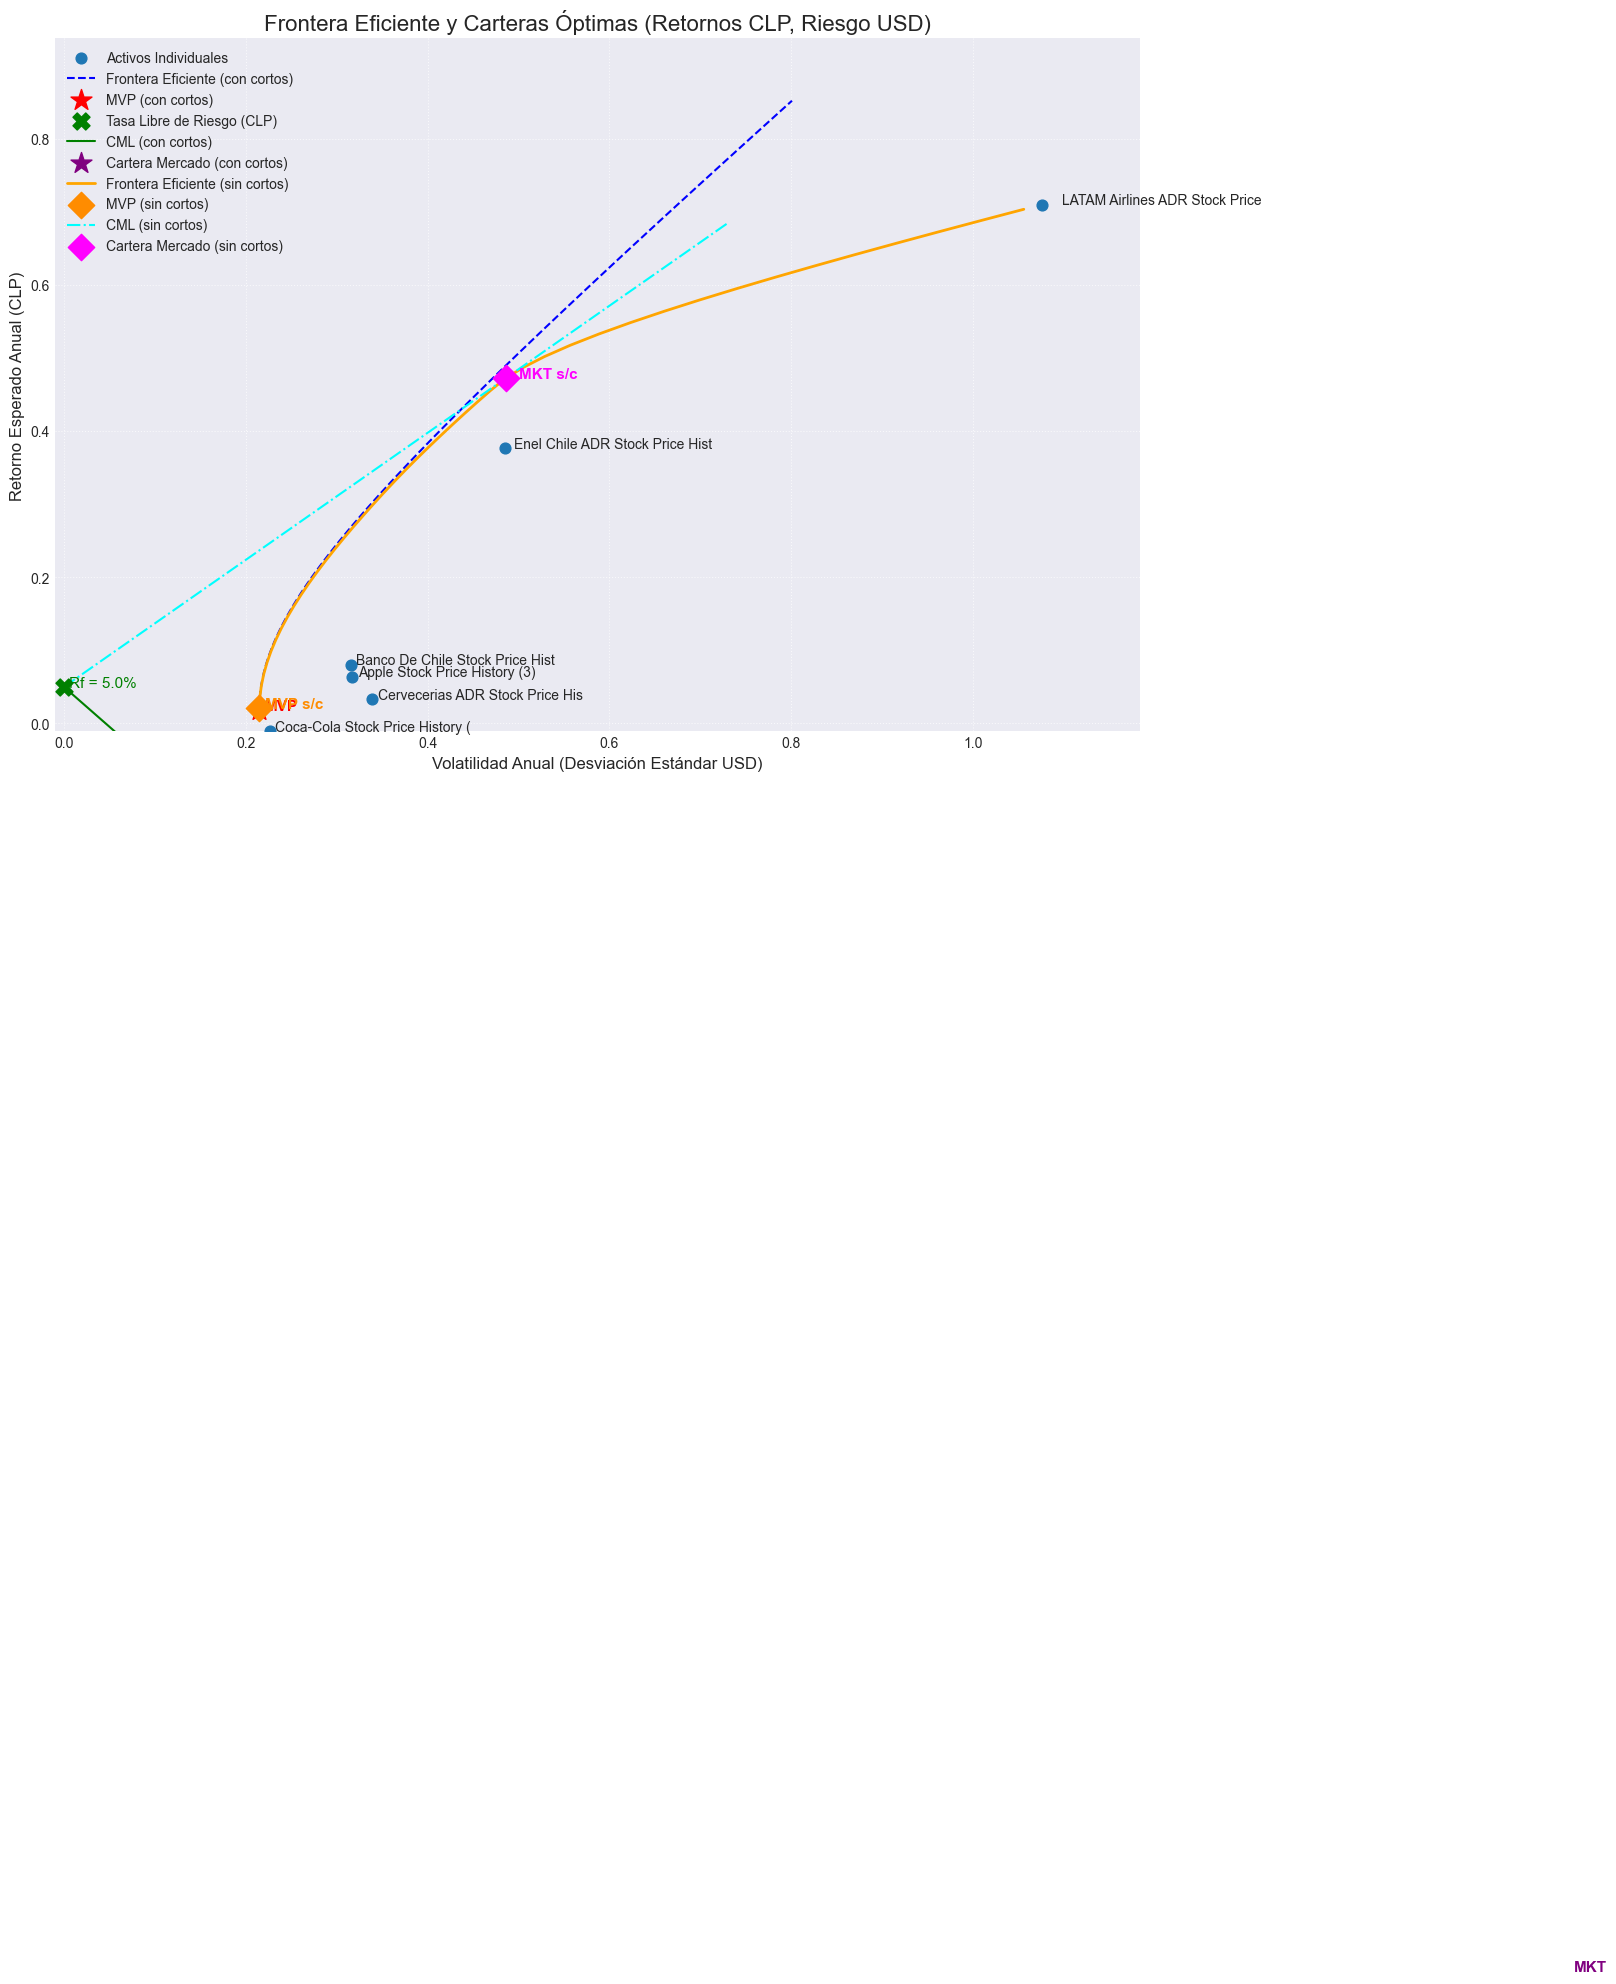

In [26]:
# --- Gráfico Completo ---
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(14, 9)) # Aumentar tamaño para mejor visualización

# Graficar Activos Individuales
asset_volatilities_plot = sigma
asset_returns_plot = mu
plt.scatter(asset_volatilities_plot, asset_returns_plot, marker='o', s=60, label='Activos Individuales', zorder=5)
for i, ticker in enumerate(returns_df.columns):
    plt.text(asset_volatilities_plot[i]*1.02, asset_returns_plot[i], ticker, fontsize=10)

# Graficar Frontera Eficiente (con ventas cortas)
plt.plot(frontier_vols, target_returns_frontier, linestyle='--', color='blue', label='Frontera Eficiente (con cortos)')

# Graficar MVP (con ventas cortas)
plt.scatter(vol_mvp, ret_mvp, marker='*', color='red', s=250, label=f'MVP (con cortos)', zorder=5)
plt.text(vol_mvp*1.03, ret_mvp, 'MVP', fontsize=11, color='red', fontweight='bold')

# Graficar Tasa Libre de Riesgo y CML (con cortos)
plt.scatter(0, r_f_clp_annual, marker='X', color='green', s=150, label='Tasa Libre de Riesgo (CLP)', zorder=5)
plt.text(0.005, r_f_clp_annual, f'Rf = {r_f_clp_annual:.1%}', fontsize=11, color='green')
# CML line points
cml_x = [0, vol_mkt * 1.5]
cml_y = [r_f_clp_annual, r_f_clp_annual + (ret_mkt - r_f_clp_annual) / vol_mkt * (vol_mkt * 1.5)]
plt.plot(cml_x, cml_y, linestyle='-', color='green', label='CML (con cortos)')

# Graficar Cartera de Mercado (Tangente con cortos)
plt.scatter(vol_mkt, ret_mkt, marker='*', color='purple', s=250, label='Cartera Mercado (con cortos)', zorder=5)
plt.text(vol_mkt*1.03, ret_mkt, 'MKT', fontsize=11, color='purple', fontweight='bold')

# Graficar Frontera Eficiente (sin ventas cortas)
if len(frontier_vol_noshort)>0:
    plt.plot(frontier_vol_noshort, frontier_ret_noshort, linestyle='-', color='orange', linewidth=2, label='Frontera Eficiente (sin cortos)')

# Graficar MVP (sin ventas cortas)
if w_mvp_noshort is not None:
    plt.scatter(vol_mvp_noshort, ret_mvp_noshort, marker='D', color='darkorange', s=180, label=f'MVP (sin cortos)', zorder=5)
    plt.text(vol_mvp_noshort*1.03, ret_mvp_noshort, 'MVP s/c', fontsize=11, color='darkorange', fontweight='bold')

# Graficar CML (sin ventas cortas)
if w_mkt_noshort is not None:
    cml_noshort_x = [0, vol_mkt_noshort * 1.5]
    cml_noshort_y = [r_f_clp_annual, r_f_clp_annual + (ret_mkt_noshort - r_f_clp_annual) / vol_mkt_noshort * (vol_mkt_noshort * 1.5)]
    plt.plot(cml_noshort_x, cml_noshort_y, linestyle='-.', color='cyan', label='CML (sin cortos)')

    # Graficar Cartera de Mercado (Tangente sin cortos)
    plt.scatter(vol_mkt_noshort, ret_mkt_noshort, marker='D', color='magenta', s=180, label='Cartera Mercado (sin cortos)', zorder=5)
    plt.text(vol_mkt_noshort*1.03, ret_mkt_noshort, 'MKT s/c', fontsize=11, color='magenta', fontweight='bold')

# Configuraciones finales del gráfico
plt.title('Frontera Eficiente y Carteras Óptimas (Retornos CLP, Riesgo USD)', fontsize=16)
plt.xlabel('Volatilidad Anual (Desviación Estándar USD)', fontsize=12)
plt.ylabel('Retorno Esperado Anual (CLP)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(fontsize=10, loc='best')

# Ajustar límites para mejor visualización
try:
    all_vols = np.concatenate(([0], asset_volatilities_plot, frontier_vols, frontier_vol_noshort if len(frontier_vol_noshort)>0 else [0]))
    all_rets = np.concatenate(([r_f_clp_annual], asset_returns_plot, target_returns_frontier, frontier_ret_noshort if len(frontier_ret_noshort)>0 else [0]))
    valid_vols = all_vols[np.isfinite(all_vols)]
    valid_rets = all_rets[np.isfinite(all_rets)]
    plt.xlim(left=-0.01, right=np.max(valid_vols[valid_vols>=0]) * 1.1)
    plt.ylim(bottom=np.min(valid_rets) * 0.9 if np.min(valid_rets)>0 else np.min(valid_rets)*1.1,
             top=np.max(valid_rets) * 1.1)
    # Asegurarse que el eje Y incluya el Rf
    min_y_plot = plt.gca().get_ylim()[0]
    max_y_plot = plt.gca().get_ylim()[1]
    if r_f_clp_annual < min_y_plot: plt.ylim(bottom=r_f_clp_annual * 0.9)
    if r_f_clp_annual > max_y_plot: plt.ylim(top=r_f_clp_annual * 1.1)

except Exception as e:
    print(f"No se pudieron ajustar los límites del gráfico: {e}")


plt.show()